In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import entropy
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [2]:
df = pd.read_csv("data.csv", index_col = 'id')
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0


In [3]:
df = df.drop(['CustomerId', 'Surname'], axis=1)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0


In [4]:
# 檢查每個欄位的缺失值數量和比例
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100

# 結合成一個DataFrame方便查看
missing_data = pd.DataFrame({'Missing Values': missing_values_count, 'Percent': missing_values_percent})

# 輸出結果
print(missing_data)

                 Missing Values  Percent
CreditScore                   0      0.0
Geography                     0      0.0
Gender                        0      0.0
Age                           0      0.0
Tenure                        0      0.0
Balance                       0      0.0
NumOfProducts                 0      0.0
HasCrCard                     0      0.0
IsActiveMember                0      0.0
EstimatedSalary               0      0.0
Exited                        0      0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 15.1+ MB


In [6]:
# 確認哪些欄位是 object 類型
object_columns = df.select_dtypes(include=['object']).columns

# 對 object 類型欄位進行 one-hot 編碼
df = pd.get_dummies(df, columns=object_columns, drop_first=False)

df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
id,,,,,,,,,,,,,,
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0,0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,0,0,1,1,0
165030,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,1,0,0,0,1
165031,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,1,0,0,0,1


In [7]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [8]:
# 標準化數據
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# def plot_pca_by_label(degree, X, y):
#     # 進行PCA
#     pca = PCA(n_components=2) 
#     X_pca = pca.fit_transform(X)

#     # 將PCA結果轉為DataFrame
#     X_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
#     X_pca['label'] = y  # 將標籤添加到PCA結果中

#     # 繪圖
#     plt.figure(figsize=(10, 6))
    
#     # 繪製y=0的數據點，使用藍色圓點
#     plt.scatter(X_pca[X_pca['label'] == 0]['PC1'], X_pca[X_pca['label'] == 0]['PC2'], 
#                 color='blue', label='Label 0', alpha=0.5)
    
#     # 繪製y=1的數據點，使用紅色圓點
#     plt.scatter(X_pca[X_pca['label'] == 1]['PC1'], X_pca[X_pca['label'] == 1]['PC2'], 
#                 color='red', label='Label 1', alpha=0.5)

#     # 添加標題和標籤
#     plt.title(f"Poly{degree}'s PCA of variables")
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.grid(True)

#     # 顯示圖例
#     plt.legend()
    
#     # 顯示圖像
#     plt.show()

In [10]:
# # 定義多項式特徵的度數
# degrees = [1, 2, 3]  # 1表示無交乘項，2表示二次特徵交乘項，3表示三次特徵交乘項

# # 遍歷每個多項式度數
# for degree in degrees:
#     # 構建多項式特徵
#     poly = PolynomialFeatures(degree=degree, include_bias=False)
#     X_poly = poly.fit_transform(Ｘ)
#     plot_pca_by_label(degree, X_poly, y)


In [11]:
# 將數據集拆分為訓練集和測試集
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化列表以儲存不同特徵交乘項的結果
cluster_results = []

# 定義多項式特徵的度數
degrees = [1, 2, 3]  # 1表示無交乘項，2表示二次特徵交乘項，3表示三次特徵交乘項

# 遍歷每個多項式度數
for degree in degrees:
    # 構建多項式特徵
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    train_X_poly = poly.fit_transform(train_X)
    test_X_poly = poly.transform(test_X)
    
    # 遍歷不同的K值
    for k in range(1, 5):  # K從1到4
        # 對訓練集應用 KMeans 分群
        kmeans = KMeans(n_clusters=k, random_state=42)
        train_clusters = kmeans.fit_predict(train_X_poly)
        
        # 預測測試集中的群
        test_clusters = kmeans.predict(test_X_poly)
        
        # 保存分群結果
        cluster_results.append({
            'degree': degree,
            'k': k,
            'train_X_poly': train_X_poly,
            'test_X_poly': test_X_poly,
            'train_clusters': train_clusters,
            'test_clusters': test_clusters
        })

In [ ]:
# # 遍歷每個多項式度數
# for degree in degrees:
#     k_values = []

#     # 初始化畫布
#     plt.figure(figsize=(8, 6))
    
#     # 遍歷每個分群數量 k
#     for result in cluster_results:
#         if result['degree'] == degree:
#             k = result['k']
#             k_values.append(k)
            
#             # 計算並繪製train_X_poly群內的平均違約率
#             for cluster in range(k):
#                 train_avg_rate = train_y[result['train_clusters'] == cluster].mean()
#                 plt.scatter(k, train_avg_rate, facecolors='none', edgecolors='blue', marker='s')
#                 plt.text(k + 0.05, train_avg_rate, f'{train_avg_rate:.2f}', color='blue', va='center')
            
#             # 計算並繪製test_X_poly群內的平均違約率
#             for cluster in range(k):
#                 test_avg_rate = test_y[result['test_clusters'] == cluster].mean()
#                 plt.scatter(k, test_avg_rate, facecolors='none', edgecolors='red', marker='o')
#                 plt.text(k + 0.05, test_avg_rate, f'{test_avg_rate:.2f}', color='red', va='center')

#     # 添加標籤和標題
#     plt.xlabel('Number of Clusters (k)')
#     plt.ylabel('Average Default Rate')
#     plt.title(f'Average Default Rate per Cluster for Degree {degree}')
#     plt.xticks([1, 2, 3, 4])
#     plt.grid(True)
    
#     # 顯示圖像
#     plt.show()

/var/folders/2k/c_xtlwg55yb462d8cc__dtt40000gn/T/ipykernel_2560/2051088081.py:50: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(range(1, 5), entropy_results[degree]['train'], 'r-o', label='Train', marker='o')
/var/folders/2k/c_xtlwg55yb462d8cc__dtt40000gn/T/ipykernel_2560/2051088081.py:51: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b-s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(range(1, 5), entropy_results[degree]['test'], 'b-s', label='Test', marker='s')


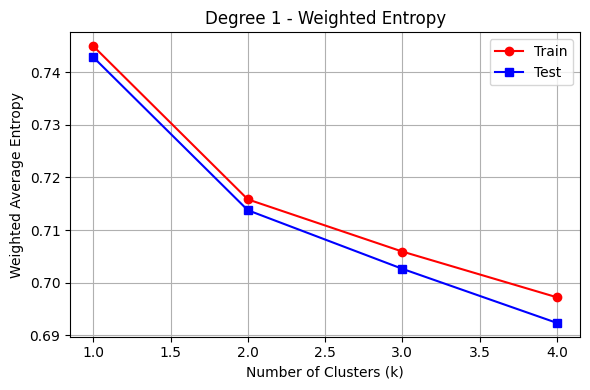

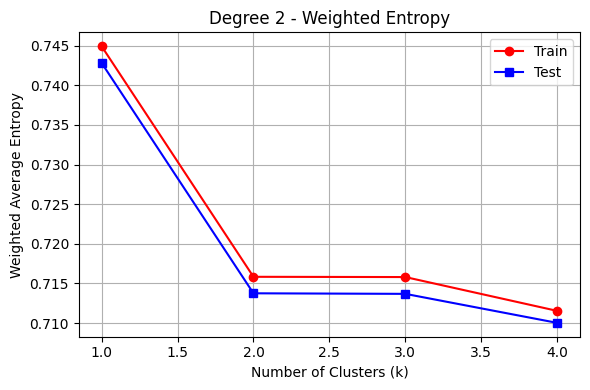

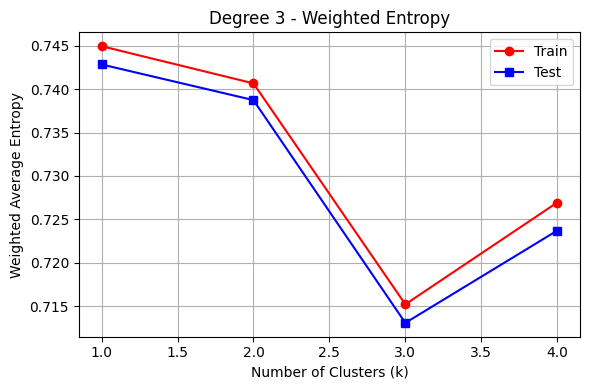

In [14]:
# 將 train_y 和 test_y 轉換為 numpy 陣列
train_y = np.array(train_y)
test_y = np.array(test_y)

def calculate_weighted_entropy(clusters, y):
    # 獲取唯一的群組
    unique_clusters = np.unique(clusters)
    weighted_entropy = 0
    total_samples = len(y)
    
    # 計算每個群組的加權熵
    for cluster in unique_clusters:
        # 獲取該群組的索引
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_labels = y[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_size = len(cluster_indices)
        
        # 計算該群組的熵
        cluster_entropy = entropy(list(label_counts.values()), base=2)
        
        # 根據該群組在總樣本中的比例計算加權熵
        weighted_entropy += (cluster_size / total_samples) * cluster_entropy
    
    return weighted_entropy

# 初始化列表以存儲熵結果
entropy_results = {
    1: {'train': [], 'test': []},
    2: {'train': [], 'test': []},
    3: {'train': [], 'test': []}
}

# 計算每個分群結果的加權平均熵
for result in cluster_results:
    degree = result['degree']
    train_clusters = result['train_clusters']
    test_clusters = result['test_clusters']
    
    train_entropy = calculate_weighted_entropy(train_clusters, train_y)
    test_entropy = calculate_weighted_entropy(test_clusters, test_y)
    
    # 儲存計算結果
    entropy_results[degree]['train'].append(train_entropy)
    entropy_results[degree]['test'].append(test_entropy)

# 分別繪製熵的變化趨勢圖
for degree in [1, 2, 3]:
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, 5), entropy_results[degree]['train'], 'r-o', label='Train', marker='o')
    plt.plot(range(1, 5), entropy_results[degree]['test'], 'b-s', label='Test', marker='s')
    plt.title(f'Degree {degree} - Weighted Entropy')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Weighted Average Entropy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# 初始化列表以儲存模型結果
results = []

# 針對每個分群結果進行預測
for cluster_data in cluster_results:
    degree = cluster_data['degree']
    k = cluster_data['k']
    train_X_poly = cluster_data['train_X_poly']
    test_X_poly = cluster_data['test_X_poly']
    train_clusters = cluster_data['train_clusters']
    test_clusters = cluster_data['test_clusters']
    
    # 初始化列表以儲存每個群的 AUC 分數和模型
    auc_scores_lr = []
    auc_scores_xgb = []
    logistic_models = []
    xgb_models = []
    
    # 針對每個群進行邏輯斯回歸和 XGBoost 模型訓練
    for cluster in range(k):
        cluster_X_train = train_X_poly[train_clusters == cluster]
        cluster_y_train = train_y[train_clusters == cluster]
        
        logistic_model = LogisticRegression(random_state=42, max_iter=1000)
        logistic_model.fit(cluster_X_train, cluster_y_train)
        
        xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        xgb_model.fit(cluster_X_train, cluster_y_train)
        
        y_pred_lr = cross_val_predict(logistic_model, cluster_X_train, cluster_y_train, cv=5, method='predict_proba')[:, 1]
        y_pred_xgb = cross_val_predict(xgb_model, cluster_X_train, cluster_y_train, cv=5, method='predict_proba')[:, 1]
        
        auc_lr = roc_auc_score(cluster_y_train, y_pred_lr)
        auc_xgb = roc_auc_score(cluster_y_train, y_pred_xgb)
        auc_scores_lr.append(auc_lr)
        auc_scores_xgb.append(auc_xgb)
        
        logistic_models.append(logistic_model)
        xgb_models.append(xgb_model)
    
    # 聚合所有模型的測試集預測結果
    test_probs_lr = np.zeros(len(test_X_poly))
    test_probs_xgb = np.zeros(len(test_X_poly))
    
    for cluster, (logistic_model, xgb_model) in enumerate(zip(logistic_models, xgb_models)):
        cluster_indices = np.where(test_clusters == cluster)[0]
        if len(cluster_indices) > 0:
            test_probs_lr[cluster_indices] = logistic_model.predict_proba(test_X_poly[cluster_indices])[:, 1]
            test_probs_xgb[cluster_indices] = xgb_model.predict_proba(test_X_poly[cluster_indices])[:, 1]
    
    test_auc_lr = roc_auc_score(test_y, test_probs_lr)
    test_auc_xgb = roc_auc_score(test_y, test_probs_xgb)
    
    # 計算測試集的 recall 和 precision
    test_preds_lr = (test_probs_lr > 0.5).astype(int)
    test_preds_xgb = (test_probs_xgb > 0.5).astype(int)
    
    precision_lr = precision_score(test_y, test_preds_lr)
    recall_lr = recall_score(test_y, test_preds_lr)
    precision_xgb = precision_score(test_y, test_preds_xgb)
    recall_xgb = recall_score(test_y, test_preds_xgb)
    
    # 保存結果
    results.append({
        'degree': degree,
        'k': k,
        'auc_scores_lr': auc_scores_lr,
        'auc_scores_xgb': auc_scores_xgb,
        'test_auc_lr': test_auc_lr,
        'test_auc_xgb': test_auc_xgb,
        'test_precision_lr': precision_lr,
        'test_recall_lr': recall_lr,
        'test_precision_xgb': precision_xgb,
        'test_recall_xgb': recall_xgb
    })

In [ ]:
# 最後輸出每個多項式度數和K值的結果
for result in results:
    print(f"特徵交乘項度數: {result['degree']}, K值: {result['k']}")
    print('各群的 邏輯斯回歸 AUC 值:', result['auc_scores_lr'])
    print('各群的 XGBoost AUC 值:', result['auc_scores_xgb'])
    print('-' * 50)

In [ ]:
# 最後輸出每個多項式度數和K值的結果
for result in results:
    print(f"特徵交乘項度數: {result['degree']}, K值: {result['k']}")
    print('測試集 邏輯斯回歸 AUC 值:', result['test_auc_lr'])
    print('測試集 XGBoost AUC 值:', result['test_auc_xgb'])
    print('-' * 50)

In [ ]:
# 最後輸出每個多項式度數和K值的結果
for result in results:
    print(f"特徵交乘項度數: {result['degree']}, K值: {result['k']}")
    print('測試集 邏輯斯回歸 Precision 值:', result['test_precision_lr'])
    print('測試集 XGBoost Precision 值:', result['test_precision_xgb'])
    print('-' * 50)

In [ ]:
# 最後輸出每個多項式度數和K值的結果
for result in results:
    print(f"特徵交乘項度數: {result['degree']}, K值: {result['k']}")
    print('測試集 邏輯斯回歸 Recall 值:', result['test_recall_lr'])
    print('測試集 XGBoost Recall 值:', result['test_recall_xgb'])
    print('-' * 50)

In [ ]:
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# # 初始化列表以儲存不同特徵交乘項的結果
# results = []

# # 定義多項式特徵的度數
# degrees = [1, 2, 3]  # 1表示無交乘項，2表示二次特徵交乘項，3表示三次特徵交乘項

# # 遍歷每個多項式度數
# for degree in degrees:
#     # 構建多項式特徵
#     poly = PolynomialFeatures(degree=degree, include_bias=False)
#     train_X_poly = poly.fit_transform(train_X)
#     test_X_poly = poly.transform(test_X)
    
#     # 遍歷不同的K值
#     for k in range(1, 5):  # K從1到4
#         # 對訓練集應用 KMeans 分群
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         train_clusters = kmeans.fit_predict(train_X_poly)
        
#         # 預測測試集中的群
#         test_clusters = kmeans.predict(test_X_poly)
        
#         # 初始化列表以儲存每個群的 AUC 分數和模型
#         auc_scores_lr = []
#         auc_scores_xgb = []
#         precision_scores_lr = []
#         recall_scores_lr = []
#         precision_scores_xgb = []
#         recall_scores_xgb = []
#         logistic_models = []
#         xgb_models = []
        
#         # 針對每個群進行邏輯斯回歸和 XGBoost 模型訓練
#         for cluster in range(k):
#             cluster_X_train = train_X_poly[train_clusters == cluster]
#             cluster_y_train = train_y[train_clusters == cluster]
            
#             logistic_model = LogisticRegression(random_state=42, max_iter=1000)
#             logistic_model.fit(cluster_X_train, cluster_y_train)
            
#             xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
#             xgb_model.fit(cluster_X_train, cluster_y_train)
            
#             y_pred_lr = cross_val_predict(logistic_model, cluster_X_train, cluster_y_train, cv=5, method='predict_proba')[:, 1]
#             y_pred_xgb = cross_val_predict(xgb_model, cluster_X_train, cluster_y_train, cv=5, method='predict_proba')[:, 1]
            
#             auc_lr = roc_auc_score(cluster_y_train, y_pred_lr)
#             auc_xgb = roc_auc_score(cluster_y_train, y_pred_xgb)
#             auc_scores_lr.append(auc_lr)
#             auc_scores_xgb.append(auc_xgb)
            
#             logistic_models.append(logistic_model)
#             xgb_models.append(xgb_model)
        
#         # 聚合所有模型的測試集預測結果
#         test_probs_lr = np.zeros(len(test_X_poly))
#         test_probs_xgb = np.zeros(len(test_X_poly))
        
#         for cluster, (logistic_model, xgb_model) in enumerate(zip(logistic_models, xgb_models)):
#             cluster_indices = np.where(test_clusters == cluster)[0]
#             if len(cluster_indices) > 0:
#                 test_probs_lr[cluster_indices] = logistic_model.predict_proba(test_X_poly[cluster_indices])[:, 1]
#                 test_probs_xgb[cluster_indices] = xgb_model.predict_proba(test_X_poly[cluster_indices])[:, 1]
        
#         test_auc_lr = roc_auc_score(test_y, test_probs_lr)
#         test_auc_xgb = roc_auc_score(test_y, test_probs_xgb)
        
#         # 計算測試集的 recall 和 precision
#         test_preds_lr = (test_probs_lr > 0.5).astype(int)
#         test_preds_xgb = (test_probs_xgb > 0.5).astype(int)
        
#         precision_lr = precision_score(test_y, test_preds_lr)
#         recall_lr = recall_score(test_y, test_preds_lr)
#         precision_xgb = precision_score(test_y, test_preds_xgb)
#         recall_xgb = recall_score(test_y, test_preds_xgb)
        
#         # 保存結果
#         results.append({
#             'degree': degree,
#             'k': k,
#             'auc_scores_lr': auc_scores_lr,
#             'auc_scores_xgb': auc_scores_xgb,
#             'test_auc_lr': test_auc_lr,
#             'test_auc_xgb': test_auc_xgb,
#             'test_precision_lr': precision_lr,
#             'test_recall_lr': recall_lr,
#             'test_precision_xgb': precision_xgb,
#             'test_recall_xgb': recall_xgb
#         })

# # 最後輸出每個多項式度數和K值的結果
# for result in results:
#     print(f"特徵交乘項度數: {result['degree']}, K值: {result['k']}")
#     print('各群的 邏輯斯回歸 AUC 值:', result['auc_scores_lr'])
#     print('各群的 XGBoost AUC 值:', result['auc_scores_xgb'])
#     print('測試集 邏輯斯回歸 AUC 值:', result['test_auc_lr'])
#     print('測試集 XGBoost AUC 值:', result['test_auc_xgb'])
#     print('測試集 邏輯斯回歸 Precision 值:', result['test_precision_lr'])
#     print('測試集 邏輯斯回歸 Recall 值:', result['test_recall_lr'])
#     print('測試集 XGBoost Precision 值:', result['test_precision_xgb'])
#     print('測試集 XGBoost Recall 值:', result['test_recall_xgb'])
#     print('-' * 50)


In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# # 初始化列表以儲存不同特徵交乘項的結果
# results = []

# # 定義多項式特徵的度數
# degrees = [1, 2, 3]  # 1表示無交乘項，2表示二次特徵交乘項，3表示三次特徵交乘項

# for degree in degrees:
#     # 構建多項式特徵
#     poly = PolynomialFeatures(degree=degree, include_bias=False)
#     train_X_poly = poly.fit_transform(train_X)
#     test_X_poly = poly.transform(test_X)
    
#     # 對訓練集應用 KMeans 分群，設置群數為 4
#     kmeans = KMeans(n_clusters=4, random_state=42)
#     train_clusters = kmeans.fit_predict(train_X_poly)
    
#     # 預測測試集中的群
#     test_clusters = kmeans.predict(test_X_poly)
    
#     # 初始化列表以儲存每個群的 AUC 分數和模型
#     auc_scores_lr = []
#     auc_scores_xgb = []
#     logistic_models = []
#     xgb_models = []
    
#     # 針對每個群進行邏輯斯回歸和 XGBoost 模型訓練
#     for cluster in range(4):
#         cluster_X_train = train_X_poly[train_clusters == cluster]
#         cluster_y_train = train_y[train_clusters == cluster]
        
#         logistic_model = LogisticRegression(random_state=42, max_iter=1000)
#         logistic_model.fit(cluster_X_train, cluster_y_train)
        
#         xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
#         xgb_model.fit(cluster_X_train, cluster_y_train)
        
#         y_pred_lr = cross_val_predict(logistic_model, cluster_X_train, cluster_y_train, cv=5, method='predict_proba')[:, 1]
#         y_pred_xgb = cross_val_predict(xgb_model, cluster_X_train, cluster_y_train, cv=5, method='predict_proba')[:, 1]
        
#         auc_lr = roc_auc_score(cluster_y_train, y_pred_lr)
#         auc_xgb = roc_auc_score(cluster_y_train, y_pred_xgb)
#         auc_scores_lr.append(auc_lr)
#         auc_scores_xgb.append(auc_xgb)
        
#         logistic_models.append(logistic_model)
#         xgb_models.append(xgb_model)
    
#     # 聚合所有模型的測試集預測結果
#     test_probs_lr = np.zeros(len(test_X_poly))
#     test_probs_xgb = np.zeros(len(test_X_poly))
    
#     for cluster, (logistic_model, xgb_model) in enumerate(zip(logistic_models, xgb_models)):
#         cluster_indices = np.where(test_clusters == cluster)[0]
#         if len(cluster_indices) > 0:
#             test_probs_lr[cluster_indices] = logistic_model.predict_proba(test_X_poly[cluster_indices])[:, 1]
#             test_probs_xgb[cluster_indices] = xgb_model.predict_proba(test_X_poly[cluster_indices])[:, 1]
    
#     test_auc_lr = roc_auc_score(test_y, test_probs_lr)
#     test_auc_xgb = roc_auc_score(test_y, test_probs_xgb)
    
#     # 保存結果
#     results.append({
#         'degree': degree,
#         'auc_scores_lr': auc_scores_lr,
#         'auc_scores_xgb': auc_scores_xgb,
#         'test_auc_lr': test_auc_lr,
#         'test_auc_xgb': test_auc_xgb
#     })

# # 最後輸出每個多項式度數的結果
# for result in results:
#     print(f"特徵交乘項度數: {result['degree']}")
#     print('各群的 邏輯斯回歸 AUC 值:', result['auc_scores_lr'])
#     print('各群的 XGBoost AUC 值:', result['auc_scores_xgb'])
#     print('測試集 邏輯斯回歸 AUC 值:', result['test_auc_lr'])
#     print('測試集 XGBoost AUC 值:', result['test_auc_xgb'])
#     print('-' * 50)

In [ ]:
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# # 對訓練集應用 KMeans 分群，設置群數為 4
# kmeans = KMeans(n_clusters=4, random_state=42)
# train_clusters = kmeans.fit_predict(train_X)

# # 預測測試集中的群
# test_clusters = kmeans.predict(test_X)

# # 初始化列表以儲存每個群的 AUC 分數和模型
# auc_scores_lr = []  # 儲存邏輯斯回歸的 AUC 分數
# auc_scores_xgb = []  # 儲存 XGBoost 的 AUC 分數
# logistic_models = []  # 儲存邏輯斯回歸模型
# xgb_models = []  # 儲存 XGBoost 模型

# # 針對每個群進行邏輯斯回歸和 XGBoost 模型訓練
# for cluster in range(4):
#     # 過濾出當前群的訓練資料
#     cluster_X_train = train_X[train_clusters == cluster]
#     cluster_y_train = train_y[train_clusters == cluster]
    
#     # 訓練邏輯斯回歸模型
#     logistic_model = LogisticRegression(random_state=42, max_iter=1000)
#     logistic_model.fit(cluster_X_train, cluster_y_train)
    
#     # 訓練 XGBoost 模型
#     xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
#     xgb_model.fit(cluster_X_train, cluster_y_train)
    
#     # 使用交叉驗證進行預測（獲得預測的概率值）
#     y_pred_lr = cross_val_predict(logistic_model, cluster_X_train, cluster_y_train, cv=5, method='predict_proba')[:, 1]
#     y_pred_xgb = cross_val_predict(xgb_model, cluster_X_train, cluster_y_train, cv=5, method='predict_proba')[:, 1]
    
#     # 計算 AUC 值
#     auc_lr = roc_auc_score(cluster_y_train, y_pred_lr)
#     auc_xgb = roc_auc_score(cluster_y_train, y_pred_xgb)
#     auc_scores_lr.append(auc_lr)
#     auc_scores_xgb.append(auc_xgb)
    
#     # 保存模型
#     logistic_models.append(logistic_model)
#     xgb_models.append(xgb_model)

# # 聚合所有模型的測試集預測結果
# test_probs_lr = np.zeros(len(test_X))  # 儲存邏輯斯回歸模型的預測結果
# test_probs_xgb = np.zeros(len(test_X))  # 儲存 XGBoost 模型的預測結果

# for cluster, (logistic_model, xgb_model) in enumerate(zip(logistic_models, xgb_models)):
#     # 過濾出當前群的測試資料
#     cluster_indices = np.where(test_clusters == cluster)[0]
#     if len(cluster_indices) > 0:
#         # 使用邏輯斯回歸模型進行預測
#         test_probs_lr[cluster_indices] = logistic_model.predict_proba(test_X[cluster_indices])[:, 1]
#         # 使用 XGBoost 模型進行預測
#         test_probs_xgb[cluster_indices] = xgb_model.predict_proba(test_X[cluster_indices])[:, 1]

# test_auc_lr = roc_auc_score(test_y, test_probs_lr)
# test_auc_xgb = roc_auc_score(test_y, test_probs_xgb)

# # 輸出每個群的 AUC 分數和測試集的 AUC 值
# print('各群的 邏輯斯回歸 AUC 值:', auc_scores_lr)
# print('各群的 XGBoost AUC 值:', auc_scores_xgb)
# print('測試集 邏輯斯回歸 AUC 值:', test_auc_lr)
# print('測試集 XGBoost AUC 值:', test_auc_xgb)